In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from data._utils import create_combined_dataset, split_combined_dataset
from train._utils import compute_loss_vectorized
from models._main import get_model
from visualize._utils import *
from omegaconf import OmegaConf
from utils import DEVICE

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
log_dir = "/home/lrvnc/Projects/worm-graph/logs/results/TS_LSTM_08_22/exp0"

# When the train loop is over, load the train dataset information to retrieve the seq_len and num_train_samples
# It assumes that all worms have the same seq_len and num_train_samples (as it is in the current implementation)
train_dataset_info = pd.read_csv(
    os.path.join(log_dir, "dataset", "train_dataset_info.csv")
)
#!seq_len = int(train_dataset_info['train_seq_len'].values[0])
#!num_train_samples = int(train_dataset_info['num_train_samples'].values[0])
#!k_splits = int(train_dataset_info['k_splits'].values[0])
tau = 1  #!int(train_dataset_info['tau'].values[0])
#!use_residual = int(train_dataset_info['use_residual'].values[0])
#!smooth_data = int(train_dataset_info['smooth_data'].values[0])

train_dataset_names = train_dataset_info["dataset"].unique().tolist()

# List of datasets and worms to be analyzed
analysis_config = OmegaConf.load(
    "/home/lrvnc/Projects/worm-graph/configs/submodule/analysis.yaml"
).analysis
datasets_and_worms = analysis_config.validation.experimental_datasets

# Loss metrics
val_running_base_loss = 0
val_running_loss = 0

dataset_val_loss = []
dataset_val_baseline = []

for dataset, worms_to_use in datasets_and_worms.items():
    # Skip some datasets
    if worms_to_use is None:
        dataset_val_loss.append(np.NaN)
        dataset_val_baseline.append(np.NaN)
        continue

    experimental_datasets = {dataset: worms_to_use}
    combined_dataset, _ = create_combined_dataset(
        experimental_datasets=experimental_datasets, num_named_neurons="all"
    )
    _, val_dataset, _ = split_combined_dataset(
        combined_dataset=combined_dataset,
        k_splits=2,  #! changeee
        num_train_samples=32,
        num_val_samples=32,  # use the same number of samples as in the train dataset
        seq_len=120,
        tau=1,
        use_residual=False,
        smooth_data=True,
        reverse=False,
    )

    valloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=32, shuffle=False, num_workers=0
    )

    # Load the model
    model_chkpt = os.path.join(log_dir, "train", "checkpoints", f"model_best.pt")
    model = get_model(OmegaConf.create({"use_this_pretrained_model": model_chkpt}))
    model.to(DEVICE)
    criterion = model.loss_fn()

    # Evaluation loop
    model.eval()

    with torch.no_grad():
        for batch_idx, (X_val, Y_val, masks_val, metadata_val) in enumerate(valloader):
            X_val = X_val.to(DEVICE)
            Y_val = Y_val.to(DEVICE)
            masks_val = masks_val.to(DEVICE)

            # If many-to-one prediction, select last time step. Else, many-to-many prediction.
            if analysis_config.validation.task == "many-to-one":
                y_base = X_val[:, -1, :].unsqueeze(1)  # Select last time step
                Y_val = Y_val[:, -1, :].unsqueeze(1)  # Select last time step
            else:
                y_base = X_val

            # Baseline model: identity model - predict that the next time step is the same as the current one.
            # This is the simplest model we can think of: predict that the next time step is the same as the current one
            # is better than predict any other random number.
            val_baseline = compute_loss_vectorized(
                loss_fn=criterion, X=y_base, Y=Y_val, masks=masks_val
            )

            # Model
            y_pred = model(X_val, masks_val, tau)

            if analysis_config.validation.task == "many-to-one":
                y_pred = y_pred[:, -1, :].unsqueeze(1)  # Select last time step

            val_loss = compute_loss_vectorized(
                loss_fn=criterion, X=y_pred, Y=Y_val, masks=masks_val
            )

            # Update running losses
            val_running_base_loss += val_baseline.item()
            val_running_loss += val_loss.item()

        # Store metrics
        dataset_val_loss.append(val_running_loss / len(valloader))
        dataset_val_baseline.append(val_running_base_loss / len(valloader))

        # Reset running losses
        val_running_base_loss = 0
        val_running_loss = 0

# Save losses in csv
losses = pd.DataFrame(
    {
        "dataset": list(datasets_and_worms.keys()),
        "val_loss": dataset_val_loss,
        "val_baseline": dataset_val_baseline,
    }
)

# Create analysis folder
os.makedirs(os.path.join(log_dir, "analysis"), exist_ok=True)
losses.to_csv(os.path.join(log_dir, "analysis", "losses.csv"), index=False)

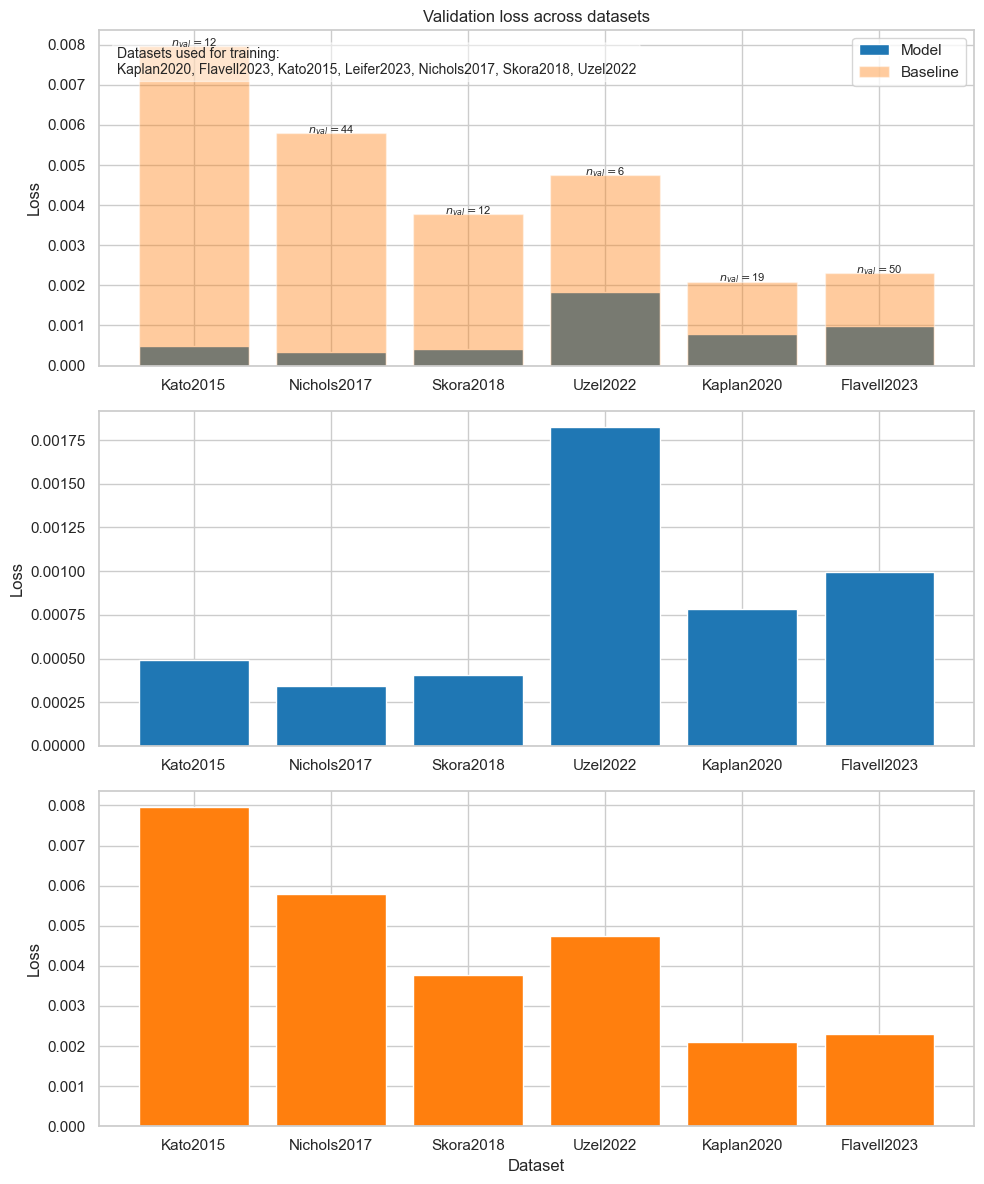

In [14]:
log_dir = "/home/lrvnc/Projects/worm-graph/logs/results/TS_LSTM_08_22/exp5"

# Acess analysis folder
analysis_dir = os.path.join(log_dir, "analysis")

# Load validation losses
losses = pd.read_csv(os.path.join(analysis_dir, "validation_loss_per_dataset.csv"))

# Drop NaNs
losses = losses.dropna()

# Train dataset names
train_info = pd.read_csv(os.path.join(log_dir, "dataset", "train_dataset_info.csv"))
train_dataset_names = train_info["dataset"].unique()

# Plot
sns.set_theme(style="whitegrid")
sns.set_palette("tab10")
palette = sns.color_palette()

fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# First plot both model and baseline losses
ax[0].bar(np.arange(len(losses)), losses["val_loss"], color=palette[0], label="Model")
ax[0].bar(
    np.arange(len(losses)),
    losses["val_baseline"],
    color=palette[1],
    label="Baseline",
    alpha=0.4,
)
ax[0].set_xticks(np.arange(len(losses)))
ax[0].set_xticklabels(losses["dataset"].values, rotation=0, ha="center")
ax[0].set_ylabel("Loss")
ax[0].set_title("Validation loss across datasets")
ax[0].legend(loc="upper right")
props = dict(boxstyle="round", facecolor="white", alpha=0.5)
textstr = "Datasets used for training: \n{}".format(", ".join(train_dataset_names))
ax[0].text(
    0.02,
    0.95,
    textstr,
    transform=ax[0].transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)
for i, v in enumerate(losses["num_worms"]):
    ax[0].text(
        i,
        max(losses.loc[i, ["val_loss", "val_baseline"]]),
        r"$n_{val} = $" + str(int(v)),
        ha="center",
        fontsize=8,
    )

# Second plot only model losses
ax[1].bar(np.arange(len(losses)), losses["val_loss"], color=palette[0], label="Model")
ax[1].set_xticks(np.arange(len(losses)))
ax[1].set_xticklabels(losses["dataset"].values, rotation=0, ha="center")
ax[1].set_ylabel("Loss")

# Third plot only baseline losses
ax[2].bar(
    np.arange(len(losses)), losses["val_baseline"], color=palette[1], label="Baseline"
)
ax[2].set_xticks(np.arange(len(losses)))
ax[2].set_xticklabels(losses["dataset"].values, rotation=0, ha="center")
ax[2].set_ylabel("Loss")
ax[2].set_xlabel("Dataset")

plt.tight_layout()
plt.show()

NameError: name 'palette' is not defined

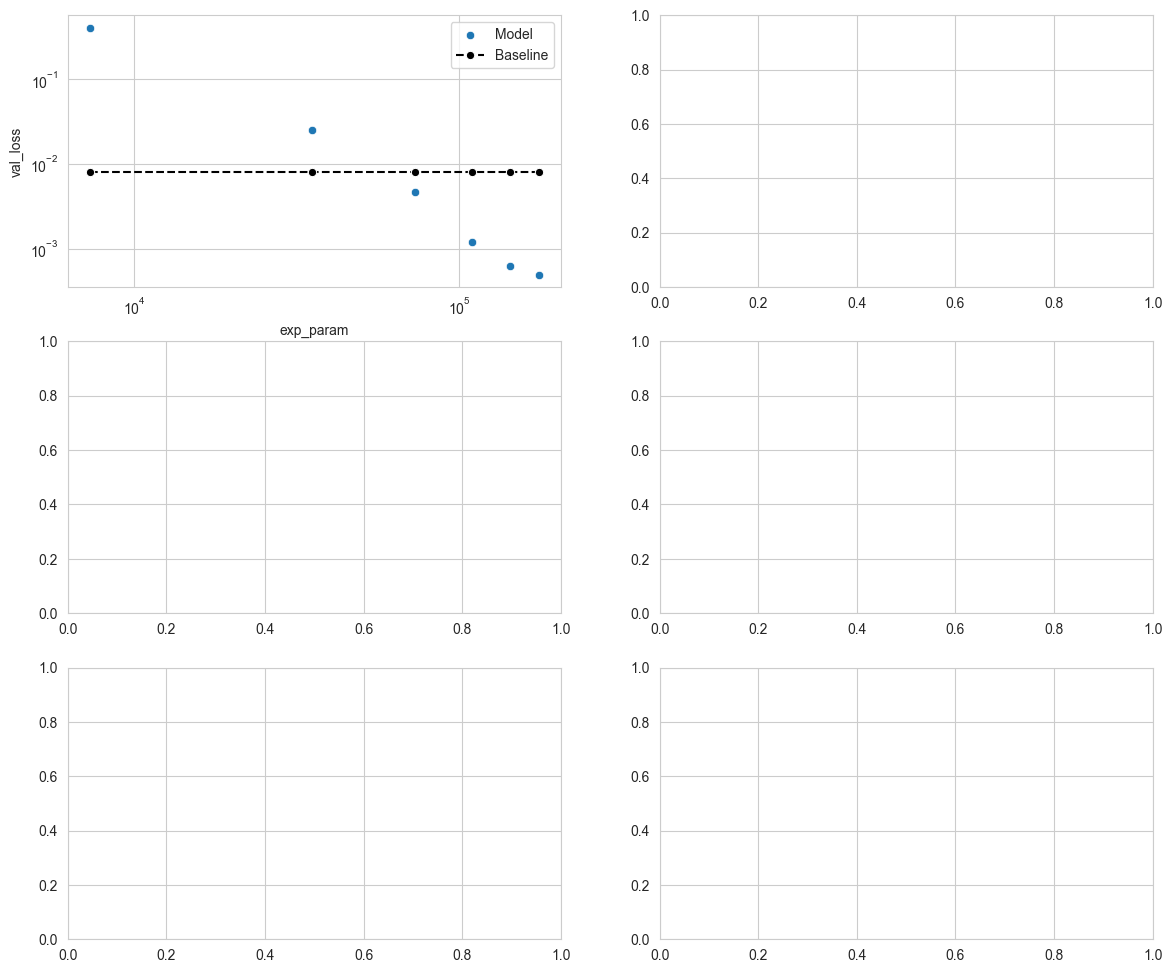

In [10]:
exp_log_dir = "/home/lrvnc/Projects/worm-graph/logs/results/TS_LSTM_08_22"

exp_name = "num_time_steps"

# Create blank dataframe
losses = pd.DataFrame(columns=["dataset", "val_loss", "val_baseline", "exp_param"])

# Loop through all experiments
for file in np.sort(os.listdir(exp_log_dir)):
    # Skip if not starts with exp
    if not file.startswith("exp") or file.startswith("exp_"):
        continue

    # Get experiment directory
    exp_dir = os.path.join(exp_log_dir, file)

    # Experiment parameters
    exp_param, exp_title, exp_xaxis = experiment_parameter(exp_dir, key=exp_name)

    # Load validation losses per dataset
    tmp_df = pd.read_csv(
        os.path.join(exp_dir, "analysis", "validation_loss_per_dataset.csv")
    )

    # Add experiment parameter to dataframe and make it multi index unique
    tmp_df["exp_param"] = exp_param

    # Load train_info
    train_info = pd.read_csv(os.path.join(exp_dir, "dataset", "train_dataset_info.csv"))

    # Dataset names used for training
    train_dataset_names = train_info["dataset"].unique()
    tmp_df["train_dataset_names"] = ", ".join(train_dataset_names)

    # Name of the model
    model_name = torch.load(
        os.path.join(exp_dir, "train", "checkpoints", "model_best.pt")
    )["model_name"]
    tmp_df["model_name"] = model_name

    # Append to dataframe
    losses = pd.concat([losses, tmp_df], axis=0)


# Make exp_param multi index with dataset
losses = losses.set_index(["exp_param", "dataset"])

# Drop NaNs
losses = losses.dropna()

# Create one subplot per dataset, arranged in two columns
num_datasets = len(losses.index.unique(level="dataset"))
num_rows = int(np.ceil(num_datasets / 2))

fig, ax = plt.subplots(num_rows, 2, figsize=(14, 12))
ax = ax.flatten()  # Flatten the ax array for easy iteration

# Plot validation loss vs. exp_param
for i, dataset in enumerate(losses.index.unique(level="dataset")):
    df_subset_model = losses.loc[
        losses.index.get_level_values("dataset") == dataset, "val_loss"
    ].reset_index()
    df_subset_baseline = losses.loc[
        losses.index.get_level_values("dataset") == dataset, "val_baseline"
    ].reset_index()

    sns.scatterplot(
        data=df_subset_model,
        x="exp_param",
        y="val_loss",
        ax=ax[i],
        label="Model",
        marker="o",
    )
    sns.lineplot(
        data=df_subset_baseline,
        x="exp_param",
        y="val_baseline",
        ax=ax[i],
        label="Baseline",
        linestyle="--",
        marker="o",
        color="black",
    )

    # Log-log scale
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")

    # Try to fit linear regression (log-log)
    try:
        x = np.log(df_subset_model["exp_param"].values)
        y = np.log(df_subset_model["val_loss"].values)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        fit_label = "y = {:.2f}x + {:.2e}\nR^2 = {:.4f}".format(
            slope, intercept, r_value**2
        )
        ax[i].plot(
            df_subset_model["exp_param"].values,
            np.exp(intercept + slope * x),
            color=palette[3],
            linestyle="-",
            label=fit_label,
        )
    except:
        pass

    # Add number of worms to title
    num_worms = losses.loc[
        losses.index.get_level_values("dataset") == dataset, "num_worms"
    ].values[0]
    ax[i].set_title(f"{dataset}: " + r"$n_{val}=$" + f"{int(num_worms)} worms")

    # Add text box with train dataset names
    # props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    # textstr = 'Datasets used for training: \n{}'.format(losses.loc[losses.index.get_level_values('dataset') == dataset, 'train_dataset_names'].values[0])
    # ax[i].text(0.02, 0.02, textstr, transform=ax[i].transAxes, fontsize=10,
    #        verticalalignment='bottom', bbox=props)

    # Add text box with model name
    model = losses.loc[
        losses.index.get_level_values("dataset") == dataset, "model_name"
    ].values[0]
    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    textstr = "Model: {}".format(model_name)
    ax[i].text(
        0.02,
        0.02,
        textstr,
        transform=ax[i].transAxes,
        fontsize=10,
        verticalalignment="bottom",
        bbox=props,
    )

    # Only set x-label for bottom row
    if i >= len(ax) - 2:
        ax[i].set_xlabel(exp_xaxis)

    # Only set y-label for leftmost columns
    if i % 2 == 0:
        ax[i].set_ylabel("Loss")

    # Remove x and y labels for subplots that shouldn't have them
    if i < len(ax) - 2:
        ax[i].set_xlabel("")
    else:
        ax[i].set_xlabel(exp_xaxis)

    if i % 2 != 0:
        ax[i].set_ylabel("")

    ax[i].legend(loc="upper right")

# Remove unused subplots
if num_datasets % 2 != 0:
    ax[-1].axis("off")

plt.tight_layout()
plt.show()

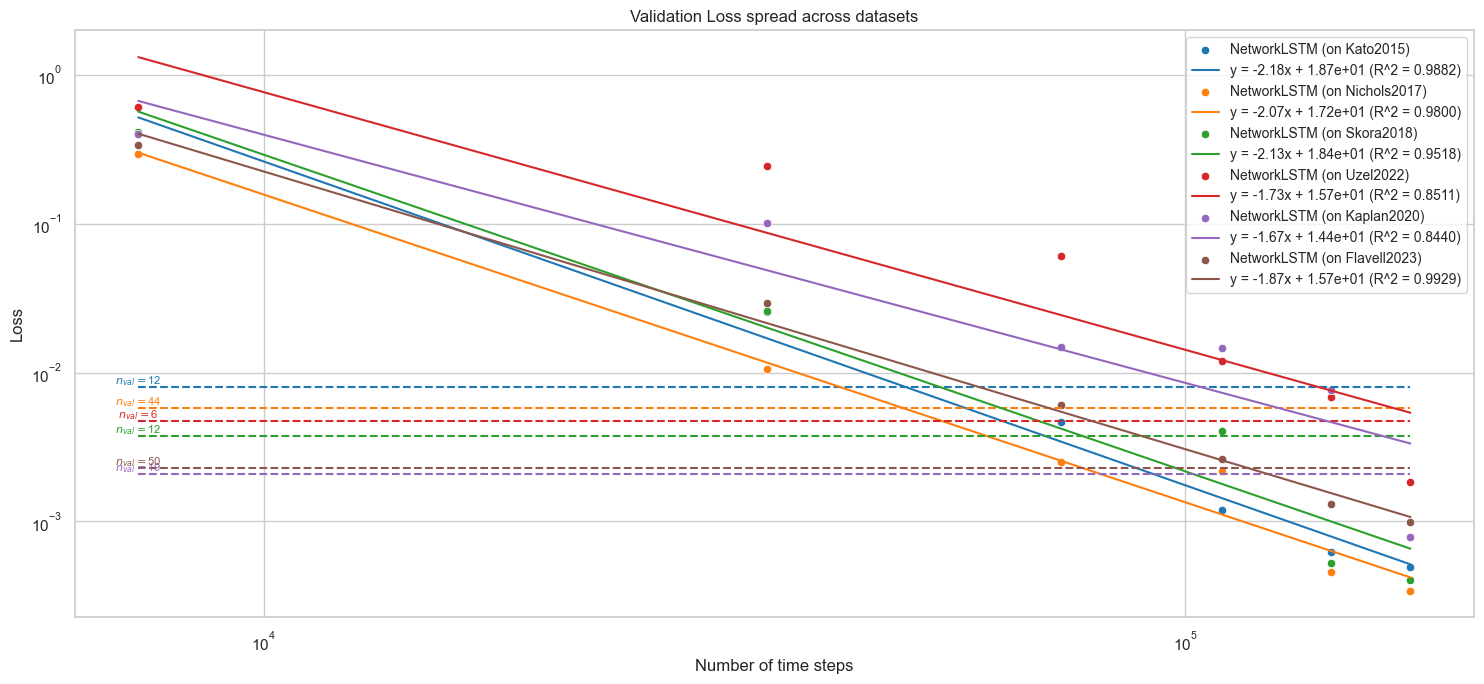

In [23]:
# Create a single plot for all datasets
fig, ax = plt.subplots(figsize=(15, 7))

# Get a color palette with enough colors for all the datasets
palette = sns.color_palette("tab10", len(losses.index.unique(level="dataset")))

# Plot validation loss vs. exp_param for all datasets
for color_idx, dataset in enumerate(losses.index.unique(level="dataset")):
    df_subset_model = losses.loc[
        losses.index.get_level_values("dataset") == dataset, "val_loss"
    ].reset_index()
    df_subset_baseline = losses.loc[
        losses.index.get_level_values("dataset") == dataset, "val_baseline"
    ].reset_index()

    model_name = losses.loc[
        losses.index.get_level_values("dataset") == dataset, "model_name"
    ].values[0]

    color = palette[color_idx]

    sns.scatterplot(
        data=df_subset_model,
        x="exp_param",
        y="val_loss",
        ax=ax,
        color=color,
        label=f"{model_name} (on {dataset})",
    )
    sns.lineplot(
        data=df_subset_baseline,
        x="exp_param",
        y="val_baseline",
        ax=ax,
        linestyle="--",
        color=color,
    )

    # Annotate number of val. worms
    num_worms = losses.loc[
        losses.index.get_level_values("dataset") == dataset, "num_worms"
    ].values[0]
    min_exp_param = df_subset_baseline["exp_param"].min()
    max_val_baseline = df_subset_baseline["val_baseline"].max()
    ax.annotate(
        r"$n_{val}=$" + f"{int(num_worms)}",
        (min_exp_param, max_val_baseline),
        textcoords="offset points",
        xytext=(0, 2),
        ha="center",
        fontsize=8,
        color=color,
    )

    # Log-log scale
    ax.set_xscale("log")
    ax.set_yscale("log")

    # Try to fit linear regression (log-log)
    try:
        x = np.log(df_subset_model["exp_param"].values)
        y = np.log(df_subset_model["val_loss"].values)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        fit_label = f"y = {slope:.2f}x + {intercept:.2e} (R^2 = {r_value**2:.4f})"
        ax.plot(
            df_subset_model["exp_param"].values,
            np.exp(intercept + slope * x),
            linestyle="-",
            color=color,
            label=fit_label,
        )
    except:
        pass

# Set axis labels and title
ax.set_xlabel(exp_xaxis)
ax.set_ylabel("Loss")
ax.set_title(f"Validation Loss spread across datasets")
ax.legend(loc="upper right", fontsize="small")

plt.tight_layout()
plt.show()

In [11]:
from visualize._utils import plot_exp_validation_loss_per_dataset

In [12]:
plot_exp_validation_loss_per_dataset(
    exp_log_dir="/home/lrvnc/Projects/worm-graph/logs/results/TS_LSTM_08_22",
    exp_name="num_time_steps",
    exp_plot_dir="/home/lrvnc/Projects/worm-graph/logs/results/TS_LSTM_08_22/exp_plots",
)

In [40]:
df = pd.read_csv(
    "/home/lrvnc/Projects/worm-graph/logs/hydra/2023_08_30_14_08_18/prediction/train/Kato2015/worm0/predictions.csv"
)

In [41]:
df

,Type,Unnamed: 1,ADAL,ADAR,ADEL,ADER,ADFL,ADFR,ADLL,ADLR,...,VD12,VD13,VD2,VD3,VD4,VD5,VD6,VD7,VD8,VD9
0,AR Generation,0,-0.069702,0.165161,-0.704102,0.359131,0.036194,-0.221191,0.299805,-0.193604,...,0.162720,0.125000,0.371826,0.348633,0.093079,0.435547,-0.150757,0.113647,0.127441,-0.086060
1,AR Generation,1,-0.133057,0.168091,-0.676270,0.415039,-0.129761,-0.201172,0.286621,-0.224609,...,0.198730,0.127075,0.295410,0.332031,0.027542,0.301025,-0.262207,0.155273,0.130615,0.005505
2,AR Generation,2,-0.150146,0.150757,-0.674316,0.388916,-0.194702,-0.225220,0.232544,-0.233398,...,0.182983,0.156250,0.344727,0.345703,-0.014954,0.252686,-0.322021,0.125366,0.073730,0.122498
3,AR Generation,3,-0.138794,0.148193,-0.668457,0.365723,-0.213135,-0.231323,0.186401,-0.227173,...,0.129883,0.188477,0.400635,0.365967,-0.053162,0.242188,-0.341797,0.114990,0.042908,0.219238
4,AR Generation,4,-0.124695,0.169800,-0.656738,0.357666,-0.203247,-0.223389,0.130859,-0.212524,...,0.065613,0.194580,0.465088,0.363037,-0.086365,0.253418,-0.346436,0.113159,0.040253,0.297119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Ground Truth,55,0.000000,-0.364248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.155369,0.000000,0.000000,-0.485659,0.000000,0.783279,0.000000
237,Ground Truth,56,0.000000,-0.312849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.142519,0.000000,0.000000,-0.451661,0.000000,0.776347,0.000000
238,Ground Truth,57,0.000000,-0.278713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.118550,0.000000,0.000000,-0.419878,0.000000,0.759827,0.000000
239,Ground Truth,58,0.000000,-0.268164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.086032,0.000000,0.000000,-0.392558,0.000000,0.735443,0.000000


In [42]:
# Select Type = 'Context'
df = df.loc[df["Type"] == "Context"]
# Select only the column names where the value is not all zeros
df = df.loc[:, (df != 0).any(axis=0)]
# Drop 'Type' and Unamed columns
df = df.drop(columns=["Type", "Unnamed: 1"])
neurons = df.columns.tolist()
neurons

['ADAR',
 'AFDL',
 'AIBL',
 'AIBR',
 'ALA',
 'ALML',
 'ALMR',
 'ALNR',
 'AS11',
 'AS2',
 'AS6',
 'AS7',
 'AS8',
 'ASGL',
 'ASJR',
 'ASKL',
 'ASKR',
 'AUAL',
 'AVAL',
 'AVAR',
 'AVBL',
 'AVBR',
 'AVEL',
 'AVFL',
 'AVFR',
 'BAGL',
 'BAGR',
 'BDUR',
 'DA3',
 'DB1',
 'DB2',
 'DD2',
 'DVA',
 'DVB',
 'FLPL',
 'HSNL',
 'I1R',
 'I4',
 'IL1DL',
 'IL1DR',
 'IL2DL',
 'IL2VR',
 'LUAL',
 'NSML',
 'OLLL',
 'OLLR',
 'OLQDL',
 'OLQDR',
 'OLQVL',
 'OLQVR',
 'PDB',
 'PDEL',
 'PHAL',
 'PHBL',
 'PVCR',
 'PVNL',
 'PVQL',
 'PVQR',
 'PVR',
 'PVWR',
 'RIAL',
 'RIBL',
 'RIBR',
 'RID',
 'RIFR',
 'RIGL',
 'RIGR',
 'RIML',
 'RIMR',
 'RIPR',
 'RIS',
 'RIVL',
 'RIVR',
 'RMDDL',
 'RMDVL',
 'RMED',
 'RMEL',
 'RMEV',
 'RMFL',
 'RMHL',
 'RMHR',
 'SAAVL',
 'SABD',
 'SABVL',
 'SABVR',
 'SDQL',
 'SIAVR',
 'SMBDL',
 'SMBDR',
 'SMBVL',
 'SMDVL',
 'URAVR',
 'URBL',
 'URXL',
 'VA1',
 'VA4',
 'VA6',
 'VB1',
 'VB10',
 'VB2',
 'VB4',
 'VB8',
 'VC2',
 'VD10',
 'VD3',
 'VD6',
 'VD8']

In [23]:
df.columns

Index(['ADAL', 'ADAR', 'ADEL', 'ADER', 'ADFL', 'ADFR', 'ADLL', 'ADLR', 'AFDL',
       'AFDR',
       ...
       'VD12', 'VD13', 'VD2', 'VD3', 'VD4', 'VD5', 'VD6', 'VD7', 'VD8', 'VD9'],
      dtype='object', length=302)